<p><center><h1>💶 Algorithme de détection automatique de faux billets</h1></center></p>
<p><center><h1>Partie 1 - Analyse</h1></center></p>

**ONCFM - Organisation nationale de lutte contre le faux-monnayage** est une organisation publique ayant pour objectif de mettre en place des méthodes d'identification des contrefaçons des billets en euros.
Dans le cadre de cette lutte, nous souhaitons mettre en place un algorithme qui soit capable de différencier automatiquement les vrais des faux billets.

## Objectifs

Lorsqu'un billet arrive, nous avons une machine qui consigne l'ensemble de ses caractéristiques géométriques. Au fil de nos années de lutte, nous avons observé des différences de dimensions entre les vrais et les faux billets. Ces différences sont difficilement visibles à l'oeil nu, mais une machine devrait sans problème arriver à les différencier.

Ainsi, il faudrait construire un algorithme qui, à partir des caractéristiques géométriques d'un billet, serait capable de définir si ce dernier est un vrai ou un faux billet.

<img src="../gfx/sep.jpg" alt="Barre">

## Chargement

***

In [1]:
# Chargement des librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.color_palette("viridis")
sns.set_theme(style="darkgrid")

from scipy import stats
from statsmodels.stats.contingency_tables import mcnemar

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, f1_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, classification_report
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

from mlxtend.evaluate import mcnemar, mcnemar_table, mcnemar_tables
from mlxtend.evaluate import paired_ttest_5x2cv, proportion_difference, paired_ttest_resampled, paired_ttest_kfold_cv

from adjustText import adjust_text

In [2]:
# Chargement des données
df = pd.read_csv("../data/billets.csv", sep=';')
df.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


<img src="../gfx/sep.jpg" alt="Barre">

## 1 - Analyse descriptive

***

### 1.1 - Description du jeu de données

Les données sont composées d'une variable cible : 
- **is_genuine**, détermine si le billet est vrai ou faux (true/false)

In [3]:
df['is_genuine'].value_counts()

is_genuine
True     1000
False     500
Name: count, dtype: int64

Le jeu de données est composé de 1500 billets, répartis de la sorte :
- 1000 vrais billets
- 500 faux billets

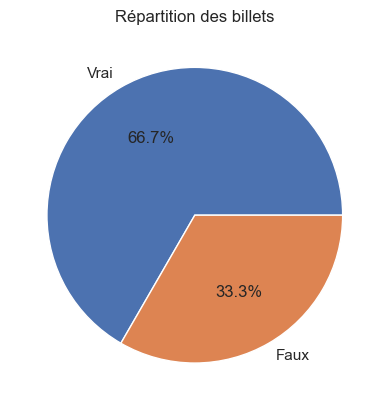

In [4]:
plt.pie(df['is_genuine'].value_counts(), labels=['Vrai', 'Faux'], autopct='%1.1f%%')
plt.title('Répartition des billets')
plt.show()

Les données comportent également 6 variables predictifs, correspondant aux dimensions géométriques des billets :
- **diagonal**, la diagonal du billet (en mm)
- **height_left**, la hauteur du billet mesurée sur le côté gauche (en mm)
- **height_right**, la hauteur du billet mesurée sur le côté droit (en mm)
- **margin_low**, la marge entre le bord inférieur du billet et l'image de celui-ci (en mm)
- **margin_up**, la marge entre le bord supérieur du billet et l'image de celui-ci (en mm)
- **length**, la longueur du billet (en mm)

In [5]:
df.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1463.000000,1500.000000,1500.00000
mean,171.958440,104.029533,103.920307,4.485967,3.151473,112.67850
std,0.305195,0.299462,0.325627,0.663813,0.231813,0.87273
min,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,171.750000,103.820000,103.710000,4.015000,2.990000,112.03000
50%,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


In [6]:
# Récupération du dataframe ne comportant que des variables numériques
df_num = df.select_dtypes(include='number')
indicateurs = df_num.columns

### 1.2 - Valeurs manquantes

In [7]:
# Vérification des valeurs manquantes
df.isna().sum()

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

> Seule la dimension **margin_low** comporte des valeurs manquantes.

> Il nous faut inférer ces valeurs manquantes à l'aide d'une ***régression linéaire*** à partir des autres variables.

In [8]:
# Copie du dataframe sans les manquants de margin_low
df_ml = df.copy()
df_ml.dropna(subset=['margin_low'], inplace=True)
# Copie du dataframe avec seulement les manquants de margin_low
df_mlna = df.copy()
df_mlna = df_mlna[df_mlna['margin_low'].isna()]

# Vérification des valeurs manquantes
df_ml.isna().sum()

is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64

In [9]:
# Conversion de la variable is_genuine en variable binaire
df_ml['is_genuine'] = df_ml['is_genuine'].astype('int')
df_ml['is_genuine'].value_counts()

is_genuine
1    971
0    492
Name: count, dtype: int64

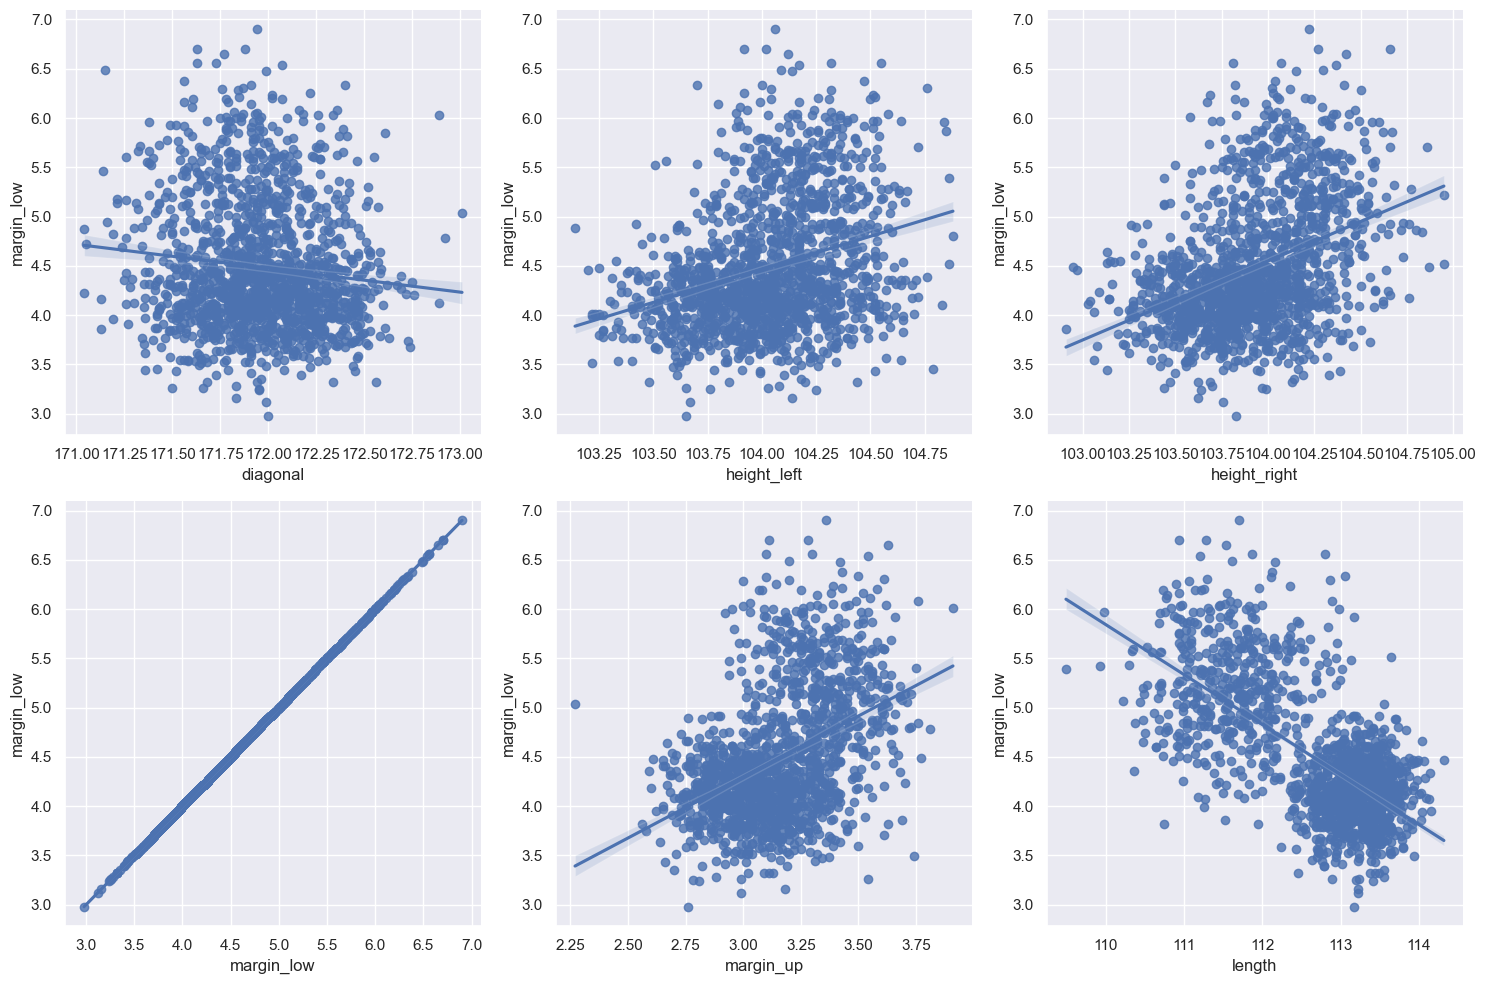

In [10]:
# Analyse bivariée
fig, ax = plt.subplots(2, 3, figsize=(15,10))

for i in range(2):
    for j in range(3):
        sns.regplot(x=df_ml[indicateurs[3*i+j]], y=df_ml['margin_low'], ax=ax[i,j])
        plt.ylabel('margin_low')
        plt.xlabel(indicateurs[3*i+j])
        plt.grid()
        sns.despine()
    
plt.tight_layout()
plt.show()

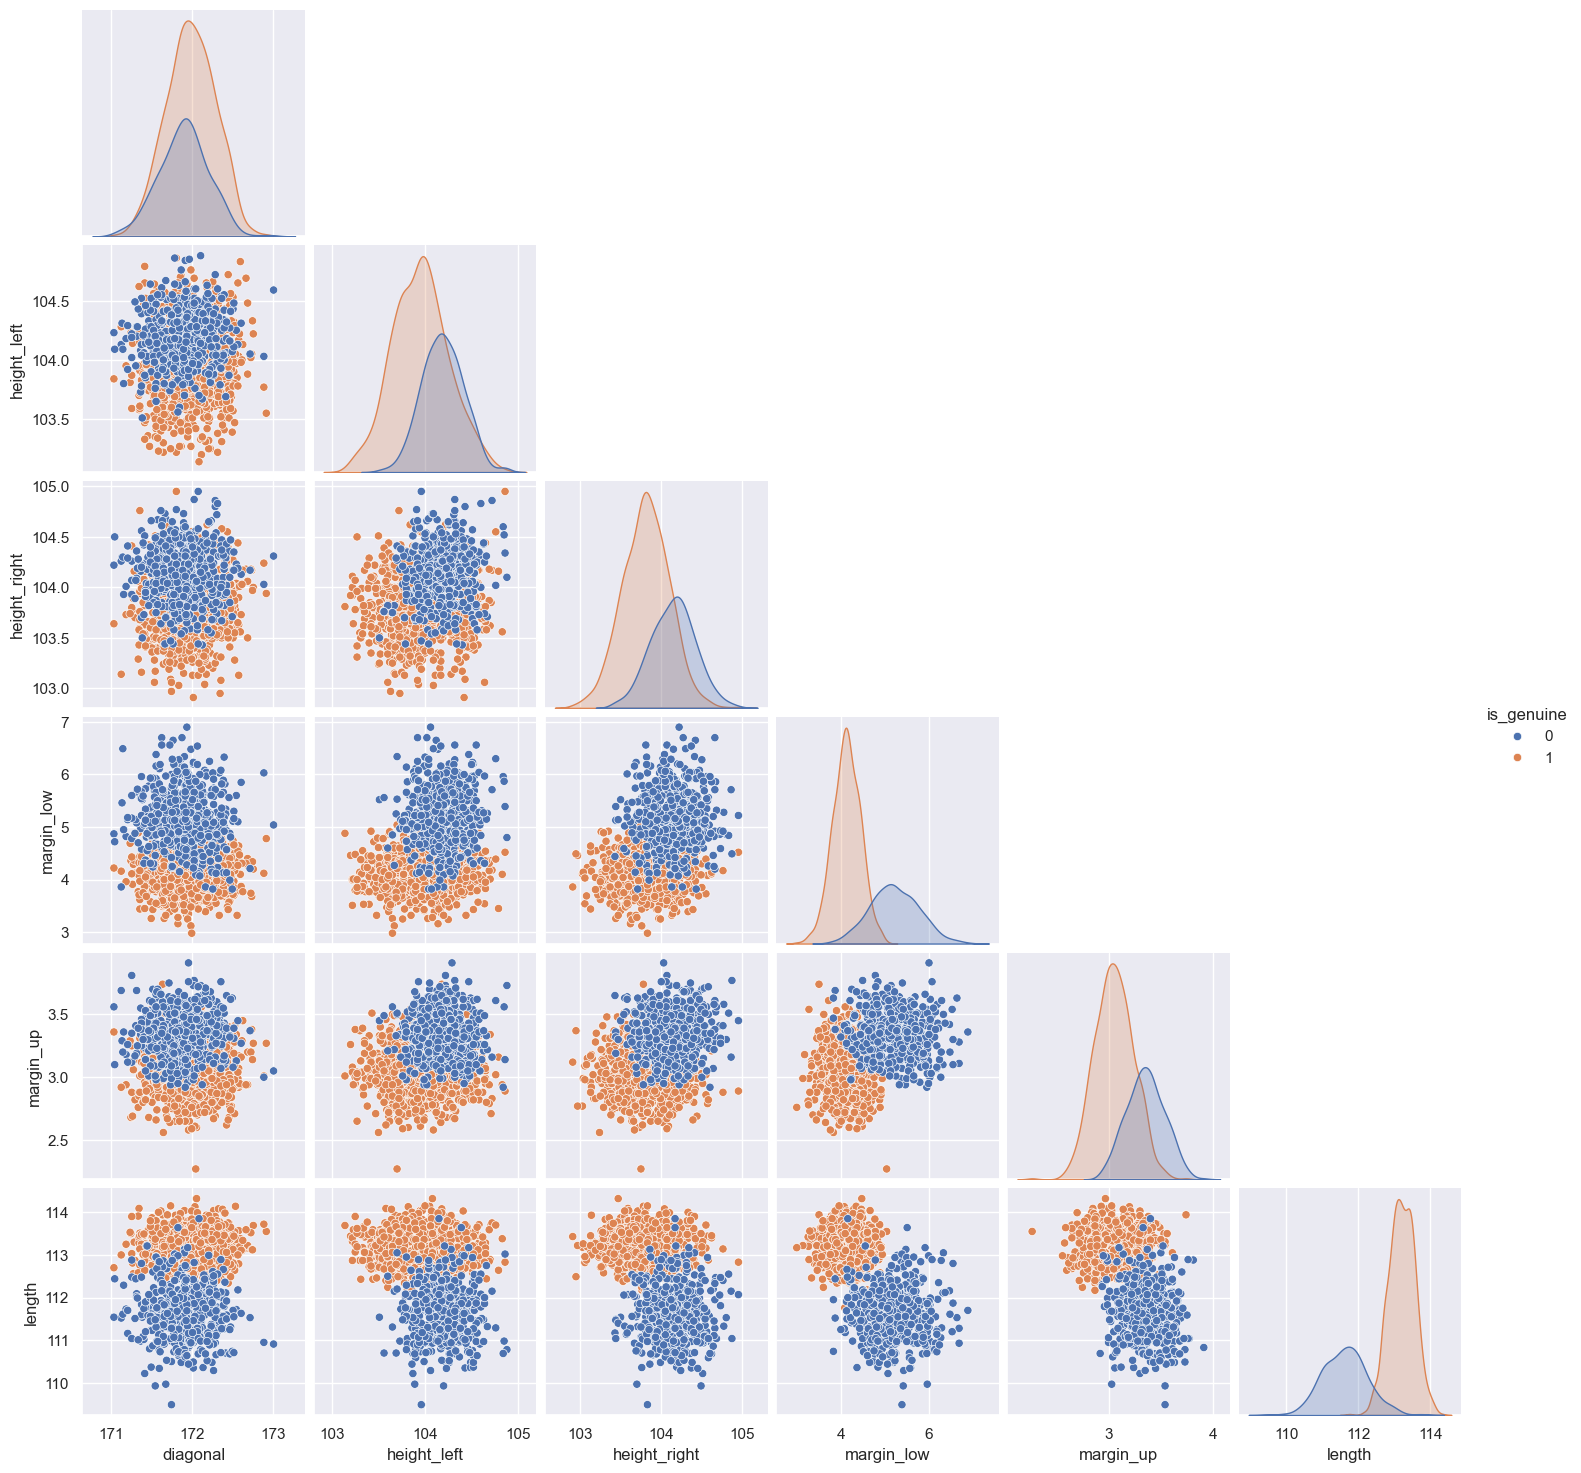

In [11]:
# Distributions croisées
sns.pairplot(df_ml, hue='is_genuine', corner=True)
plt.show()

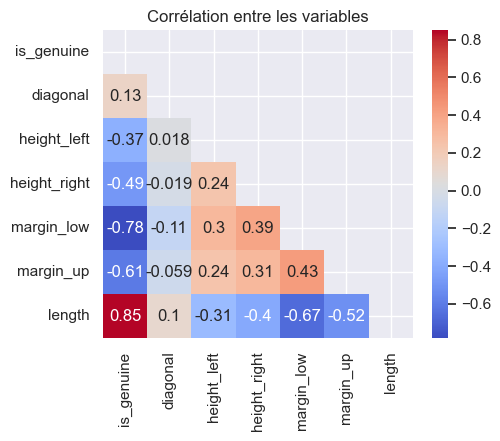

In [12]:
# Analyse des corrélations
correlation = df_ml.corr()
mask = np.triu(np.ones_like(correlation, dtype=bool))
plt.figure(figsize=(5,4))
sns.heatmap(correlation, annot=True, cmap='coolwarm', mask=mask)
plt.title('Corrélation entre les variables')
plt.show()

In [13]:
varpred = ['is_genuine', 'diagonal', 'height_left', 'height_right', 'margin_up', 'length']

# Régression linéaire
reg = LinearRegression()
X_ml = df_ml[varpred]
y_ml = df_ml['margin_low']
reg.fit(X_ml,y_ml)

LinearRegression()

In [14]:
print(f"R^2 : {np.round(reg.score(X_ml,y_ml), 3)}")
print(f"margin_low = {np.round(reg.coef_[0], 2)} * is_genuine + {np.round(reg.coef_[1], 2)} * diagonal + {np.round(reg.coef_[2], 2)} * height_left + {np.round(reg.coef_[3], 2)} * height_right + {np.round(reg.coef_[4], 2)} * margin_up + {np.round(reg.coef_[5], 2)} * length + bruit")

R^2 : 0.617
margin_low = -1.14 * is_genuine + -0.01 * diagonal + 0.03 * height_left + 0.03 * height_right + -0.21 * margin_up + -0.0 * length + bruit


In [15]:
# Prédictions
y_pred = reg.predict(X_ml)
print(f"MSE : {np.round(mean_squared_error(y_ml, y_pred), 2)}")
print(f"MAPE : {np.round(mean_absolute_percentage_error(y_ml, y_pred), 2)}")

MSE : 0.17
MAPE : 0.07


In [16]:
# Utilisation d'un scaler pour contraindre les variables entre 0 et 1
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(df_ml[varpred])
df_ml_scaled = pd.DataFrame(X_scaled, columns=varpred)
df_ml_scaled.describe().loc[['min', 'max']]

,is_genuine,diagonal,height_left,height_right,margin_up,length
min,0.0,0.0,0.0,0.0,0.0,0.0
max,1.0,1.0,1.0,1.0,1.0,1.0


In [17]:
# Scinder les données en jeu d'entraînement et de test
X_ml = df_ml_scaled[varpred]
y_ml = df_ml['margin_low']

X_train, X_test, y_train, y_test = train_test_split(X_ml, y_ml, test_size=0.2, random_state=42)

In [18]:
# Entraînement du modèle
reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression()

In [19]:
# Prédiction sur le test set
y_pred_test = reg.predict(X_test)

# Scores
print(f"RMSE: {mean_squared_error(y_test, y_pred_test)}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, y_pred_test)}")

RMSE: 0.13739452871780827
MAPE: 0.06496074172211527


> On a un très bon modèle.

In [20]:
# Inférence des manquants de margin_low
X_mlna_scaled = scaler.fit_transform(df_mlna[varpred])
df_mlna_scaled = pd.DataFrame(X_mlna_scaled, columns=varpred)
y_mlna_pred = reg.predict(df_mlna_scaled)
df_mlna['margin_low'] = np.round(y_mlna_pred, 2)

In [21]:
# Concaténation des dataframes pour obtenir un dataframe sans manquants
df = pd.concat([df_ml, df_mlna], axis=0)
df_num = df.select_dtypes(include='number')

In [22]:
# Vérification des valeurs manquantes
df.isna().sum()

is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64

In [23]:
df.describe()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.00000
mean,0.666667,171.958440,104.029533,103.920307,4.482913,3.151473,112.67850
std,0.471562,0.305195,0.299462,0.325627,0.659696,0.231813,0.87273
min,0.000000,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,0.000000,171.750000,103.820000,103.710000,4.027500,2.990000,112.03000
50%,1.000000,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,1.000000,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,1.000000,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


> Les valeurs pour margin_low sont très proches des valeurs d'avant la régression linéaire.

### 1.3 - Valeurs aberrantes ou atypiques

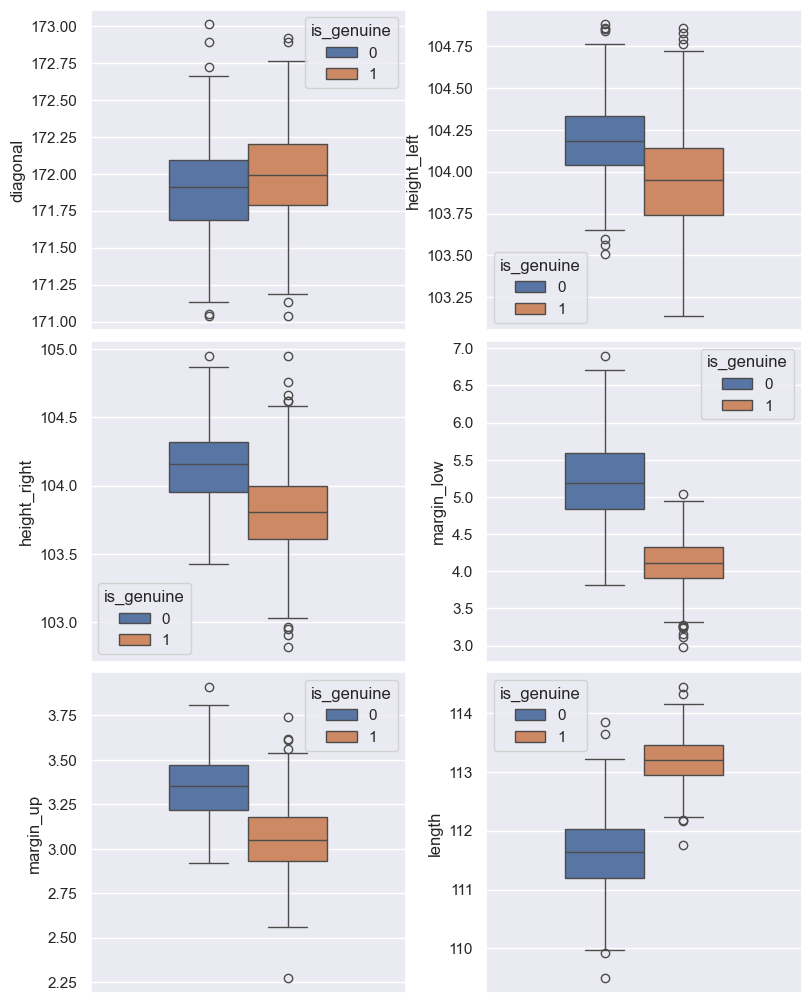

In [24]:
# Répartition des dimensions des billets
ind_j = 2
ind_i = int(len(indicateurs)/ind_j)
fig, ax = plt.subplots(ind_i, ind_j, figsize=(8,10))

for i in range(ind_i):
    for j in range(ind_j):
        #sns.boxplot(data=df_num[indicateurs[ind_j*i+j]], ax=ax[i,j], width=0.5)
        sns.boxplot(hue=df_num['is_genuine'], y=df_num[indicateurs[ind_j*i+j]], data=df_num, ax=ax[i,j], width=0.5)

fig.tight_layout(pad=0.5)
plt.show()

> Les plus grandes différences de distribution sont observées pour les dimensions ***"length", "margin_low" et "margin_up"***.

In [25]:
# Copie du dataframe pour vérification par stats
df_stats = df_num.copy()
z_indicateurs = ['z_diagonal', 'z_height_left', 'z_height_right', 'z_margin_low', 'z_margin_up', 'z_length']

# Vérification avec le Z-Score
df_stats['z_diagonal'] = stats.zscore(df_stats.diagonal)
df_stats['z_height_left'] = stats.zscore(df_stats.height_left)
df_stats['z_height_right'] = stats.zscore(df_stats.height_right)
df_stats['z_margin_low'] = stats.zscore(df_stats.margin_low)
df_stats['z_margin_up'] = stats.zscore(df_stats.margin_up)
df_stats['z_length'] = stats.zscore(df_stats.length)

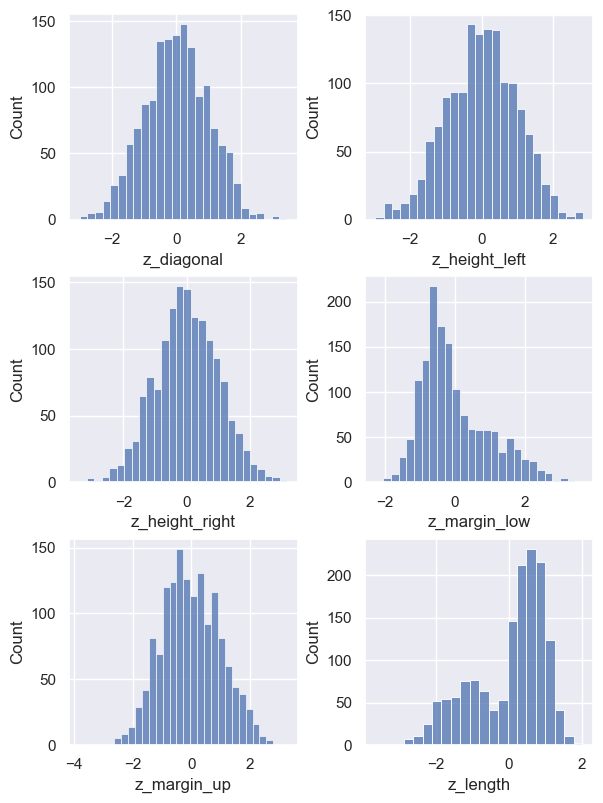

In [26]:
# Histogramme des Z-Scores
fig, ax = plt.subplots(ind_i, ind_j, figsize=(6,8))

for i in range(ind_i):
    for j in range(ind_j):
        sns.histplot(data=df_stats[z_indicateurs[ind_j*i+j]], ax=ax[i,j])

fig.tight_layout(pad=0.5)
plt.show()

> Les données dimensionnelles ne comportent ***pas de valeurs aberrantes ou atypiques***.

### 1.4 - Résumé du jeu de données

In [27]:
df_num.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1500 entries, 0 to 1438
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   int64  
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1500 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 93.8 KB


> 1500 échantillons

> 1 variable cible binaire (0 : faux billet, 1 : vrai billet)

> 6 variables prédictives

<img src="../gfx/sep.jpg" alt="Barre">

## 2 - Modèles

***

### 2.1 - Division des données

In [28]:
varpred = ['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']
X = df_num[varpred]
y = df_num['is_genuine']

# Standardisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Division
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

### 2.2 - Régression Logistique

In [29]:
# Instanciation et entraînement du modèle
reglog = LogisticRegression(random_state=808).fit(X_train, y_train)

In [30]:
# Prédiction
reglog_y_pred = reglog.predict(X_test)

### 2.3 - K-Means

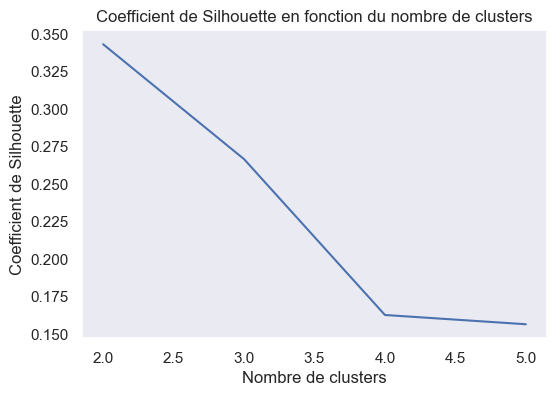

In [31]:
# Nombre optimal de clusters avec le coefficient de silhouette
silhouette_scores = []
for n_clusters in range(2, 6):
    kms = KMeans(init="k-means++", n_clusters=n_clusters, random_state=808, n_init='auto')
    kms.fit(X_scaled)
    kms_labels = kms.predict(X_scaled)
    silhouette_scores.append(silhouette_score(X_scaled, kms_labels))

fig, ax = plt.subplots(figsize=(6,4))
plt.plot(range(2, 6), silhouette_scores)
plt.xlabel('Nombre de clusters')
plt.ylabel('Coefficient de Silhouette')
plt.title('Coefficient de Silhouette en fonction du nombre de clusters')
plt.grid()
plt.show()

> Nous avons un pic du coefficient de Silhouette pour ***2 clusters***.

In [32]:
# Nombre de clusters optimal
k = 2

In [33]:
kmeans = KMeans(n_clusters=k, random_state=808, n_init='auto')
kmeans.fit(X_scaled)

print(f"Score : {kmeans.score(X_scaled)}")
print(f"Silhouette Score : {silhouette_score(X_scaled, kmeans.labels_)}")

Score : -5802.2531779268065
Silhouette Score : 0.3432401155486946


### 2.4 - K-Nearest Neighbors

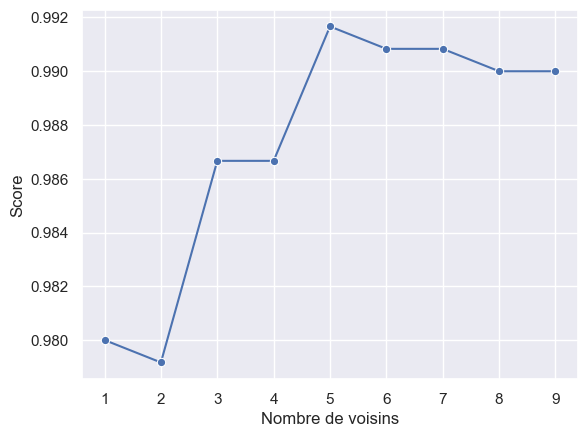

In [34]:
# Déterminer le nombre de voisins optimal
scores = []

for k in range(1, 10):
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, X_train, y_train, cv=5)
    scores.append(np.mean(score))

sns.lineplot(x=range(1, 10), y=scores, marker='o')
plt.xlabel('Nombre de voisins')
plt.ylabel('Score')
plt.show()

> Nous obtenons le meilleur score avec 5 voisins

In [35]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
knn_y_pred = knn.predict(X_test)

### 2.5 - Random Forest

In [36]:
ranfor = RandomForestClassifier(n_estimators=100, random_state=808)
ranfor.fit(X_train, y_train)
ranfor_y_pred = ranfor.predict(X_test)

### 2.6 - Gradient Boosting

In [37]:
graboo = GradientBoostingClassifier(n_estimators=100, random_state=808)
graboo.fit(X_train, y_train)
graboo_y_pred = graboo.predict(X_test)

### 2.7 - Support Vector Classification

In [38]:
svc = SVC(kernel='linear', probability=True)
svc.fit(X_train, y_train)
svc_y_pred = svc.predict(X_test)

<img src="../gfx/sep.jpg" alt="Barre">

## 3 - Evaluation des modèles

***

In [39]:
modeles = ['Régression Logistique', 'K-Means', 'K-Nearest Neighbors', 'Random Forest', 'Gradient Boosting', 'SVC']
modelessupervises = ['Régression Logistique', 'K-Nearest Neighbors', 'Random Forest', 'Gradient Boosting', 'SVC']
predictions = [reglog_y_pred, kmeans.labels_, knn_y_pred, ranfor_y_pred, graboo_y_pred, svc_y_pred]
y_refs = [y_test, y, y_test, y_test, y_test, y_test]

### 3.1 - Histogramme des probabilités

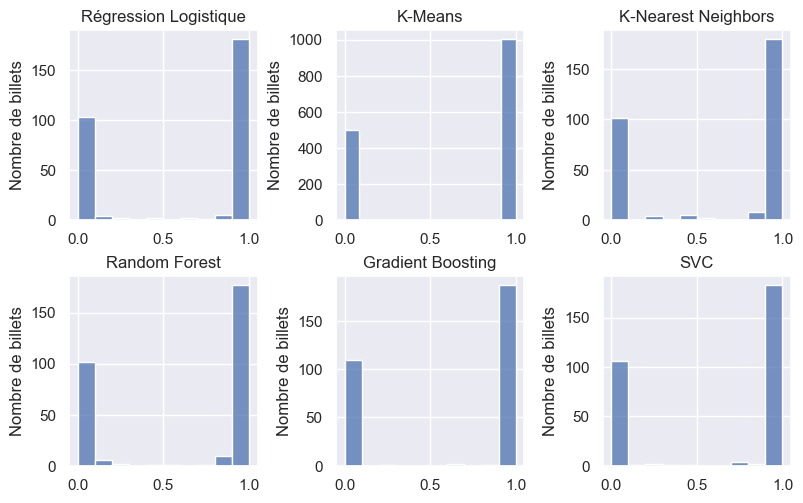

In [40]:
# Histogramme des probabilités
y_hat_probas = [reglog.predict_proba(X_test)[:,1], kmeans.labels_, knn.predict_proba(X_test)[:,1], ranfor.predict_proba(X_test)[:,1], graboo.predict_proba(X_test)[:,1], svc.predict_proba(X_test)[:,1]]

fig, ax = plt.subplots(2, 3, figsize=(8,5))

for i in range(2):
    for j in range(3):
        sns.histplot(y_hat_probas[3*i+j], ax=ax[i,j])
        ax[i,j].set_title(modeles[3*i+j])
        ax[i,j].set_ylabel('Nombre de billets')

fig.tight_layout(pad=0.5)
plt.show()

### 3.2 - Métriques

In [41]:
# Métriques
acc, cms, prec, rec, f1, roc = ([] for i in range(6))

for pred, ref in zip(predictions, y_refs):
    acc.append(accuracy_score(ref, pred))   # Accuracy
    cms.append(confusion_matrix(ref, pred)) # Matrice de confusion
    prec.append(precision_score(ref, pred)) # Precision
    rec.append(recall_score(ref, pred))     # Recall
    f1.append(f1_score(ref, pred))          # F1-Score

for i in range(6):
    if i == 1:
        roc.append(roc_auc_score(y, y_hat_probas[i]))
    else:
        roc.append(roc_auc_score(y_test, y_hat_probas[i]))

In [42]:
metriques = pd.DataFrame(
    {
        'Modèles' : modeles,
        'Accuracy' : acc,
        'Precision' : prec,
        'Recall': rec,
        'F1': f1,
        'ROC-AUC' : roc
    },
    columns=['Modèles', 'Accuracy', 'Precision', 'Recall', 'F1', 'ROC-AUC']
)
metriques

,Modèles,Accuracy,Precision,Recall,F1,ROC-AUC
0,Régression Logistique,0.993333,0.994709,0.994709,0.994709,0.999619
1,K-Means,0.984667,0.987039,0.990000,0.988517,0.982000
2,K-Nearest Neighbors,0.990000,0.989474,0.994709,0.992084,0.995090
3,Random Forest,0.993333,0.994709,0.994709,0.994709,0.999809
4,Gradient Boosting,0.983333,0.984211,0.989418,0.986807,0.998951
5,SVC,0.993333,0.994709,0.994709,0.994709,0.999619


### 3.3 - Matrices de confusion

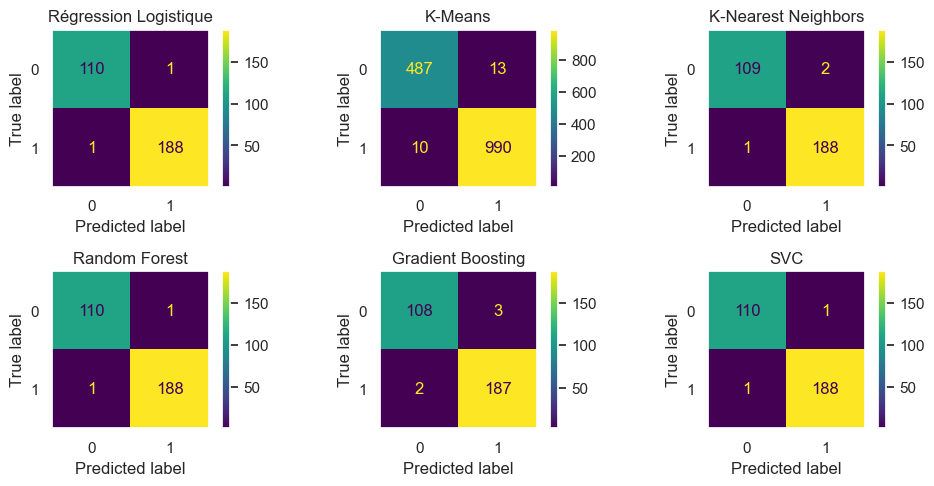

In [43]:
# Matrices de confusion
fig, ax = plt.subplots(2, 3, figsize=(10,5))

for i in range(2):
    for j in range(3):
        disp = ConfusionMatrixDisplay(confusion_matrix=cms[3*i+j], display_labels=[0, 1])
        disp.plot(ax=ax[i,j])
        ax[i,j].grid(None)
        ax[i,j].set_title(modeles[3*i+j])

fig.tight_layout(pad=1)
plt.show()

### 3.4 - Courbes ROC

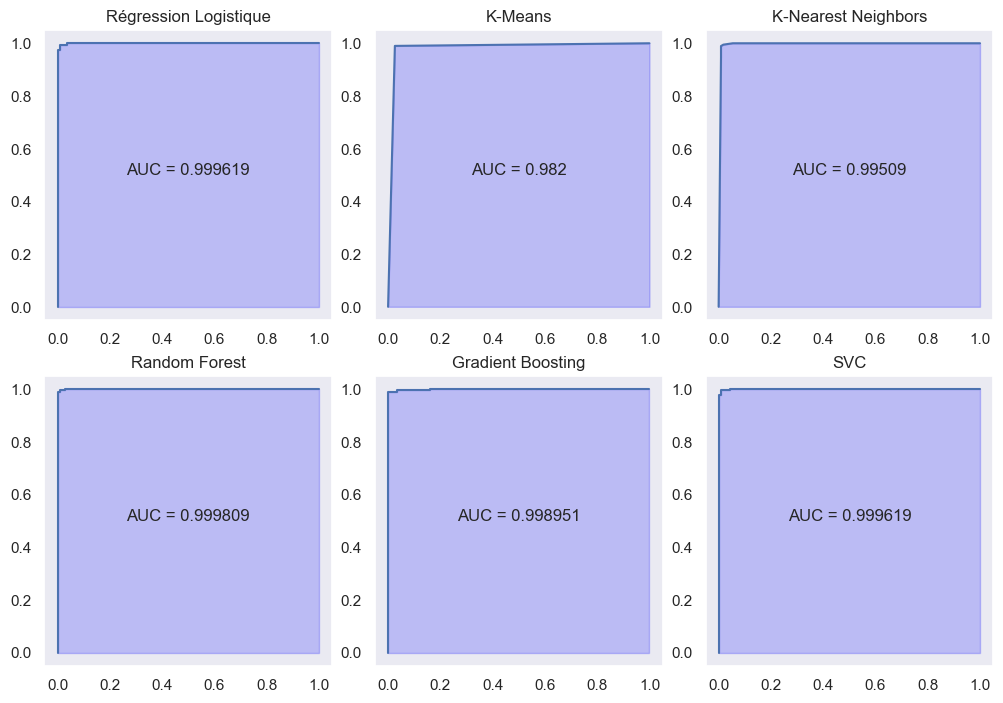

In [44]:
# Courbes ROC
fig, ax = plt.subplots(2, 3, figsize=(10,7))

for i in range(2):
    for j in range(3):
        if 3*i+j == 1:
            fpr, tpr, thresholds = roc_curve(y, y_hat_probas[3*i+j])
        else:
            fpr, tpr, thresholds = roc_curve(y_test, y_hat_probas[3*i+j])

        ax[i,j].plot(fpr, tpr)
        ax[i,j].fill_between(fpr, tpr, 0, color='blue', alpha=0.2)
        ax[i,j].text(0.5, 0.5, f"AUC = {np.round(roc[3*i+j], 6)}", horizontalalignment='center')
        ax[i,j].grid()
        ax[i,j].set_title(modeles[3*i+j])

fig.tight_layout(pad=0.5)
plt.show()

### 3.5 - Scores

In [45]:
modelesselection = ['Régression Logistique', 'Random Forest', 'SVC']
scores_train = []
scores_test = []

scores_train.append(reglog.score(X_train, y_train))
scores_test.append(reglog.score(X_test, y_test))
scores_train.append(ranfor.score(X_train, y_train))
scores_test.append(ranfor.score(X_test, y_test))
scores_train.append(svc.score(X_train, y_train))
scores_test.append(svc.score(X_test, y_test))

scores_sel = pd.DataFrame(
    {
        'Modèles' : modelesselection,
        'Score Train': scores_train,
        'Score Test': scores_test
    },
    columns=['Modèles', 'Score Train', 'Score Test']
)
scores_sel

,Modèles,Score Train,Score Test
0,Régression Logistique,0.993333,0.993333
1,Random Forest,1.000000,0.993333
2,SVC,0.993333,0.993333


 <img src="../gfx/sep.jpg" alt="Barre">

## 4 - Optimisation des modèles sélectionnés

***

### 4.1 - Hyperparamètres pour la Régression Logistique

In [46]:
# Définition de l'étendu des paramètres
reglog_param = dict(
    C=np.logspace(-3, 3, 7),
    penalty=['l2'],
    max_iter=range(100, 500),
    warm_start=[True, False],
    solver=['lbfgs', 'newton-cg', 'liblinear']
)

In [47]:
rand_reglog = RandomizedSearchCV(reglog, reglog_param, random_state=42, n_jobs=-1, verbose=1, cv=5)
rand_reglog.fit(X_train, y_train)
print(rand_reglog.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'warm_start': True, 'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 437, 'C': 0.01}


In [48]:
rand_reglog_pred = rand_reglog.predict(X_test)
print(classification_report(y_test, rand_reglog_pred, digits=6))

              precision    recall  f1-score   support

           0   0.990991  0.990991  0.990991       111
           1   0.994709  0.994709  0.994709       189

    accuracy                       0.993333       300
   macro avg   0.992850  0.992850  0.992850       300
weighted avg   0.993333  0.993333  0.993333       300



In [49]:
# Régression Logistique finale
reglog_final = LogisticRegression(**rand_reglog.best_params_)
reglog_final.fit(X_train, y_train)
# Prédictions sur le jeu de test
reglog_final_pred = reglog_final.predict(X_test)
# Affichage du rapport de classification
print(classification_report(y_test, reglog_final_pred, digits=6))

              precision    recall  f1-score   support

           0   0.990991  0.990991  0.990991       111
           1   0.994709  0.994709  0.994709       189

    accuracy                       0.993333       300
   macro avg   0.992850  0.992850  0.992850       300
weighted avg   0.993333  0.993333  0.993333       300



In [50]:
# Accuracy
print(f"Accuracy : {accuracy_score(y_test, reglog_final_pred)}")
# Precision
print(f"Precision : {precision_score(y_test, reglog_final_pred)}")
# Recall
print(f"Recall : {recall_score(y_test, reglog_final_pred)}")

Accuracy : 0.9933333333333333
Precision : 0.9947089947089947
Recall : 0.9947089947089947


In [51]:
# Score Train
print(f"Score Train : {reglog_final.score(X_train, y_train)}")
# Score Test
print(f"Score Test : {reglog_final.score(X_test, y_test)}")

Score Train : 0.9908333333333333
Score Test : 0.9933333333333333


### 4.2 - Hyperparamètres pour Random Forest

In [52]:
# Définition de l'étendue des paramètres
ranfor_param = dict(
    n_estimators=list(range(10, 100, 10)),
    max_features=['sqrt', 'log2'],
    max_depth=list(range(1, 11, 1)),
    min_samples_split=list(range(2, 10, 1)),
    min_samples_leaf=list(range(1, 10, 1)),
    bootstrap=[True, False]
)

In [53]:
rand_ranfor = RandomizedSearchCV(ranfor, ranfor_param, n_jobs=-1, cv=5, verbose=1)
rand_ranfor.fit(X_train, y_train)
print(rand_ranfor.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'n_estimators': 70, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 4, 'bootstrap': True}


In [54]:
rand_ranfor_pred = rand_ranfor.predict(X_test)
print(classification_report(y_test, rand_ranfor_pred, digits=6))

              precision    recall  f1-score   support

           0   0.990909  0.981982  0.986425       111
           1   0.989474  0.994709  0.992084       189

    accuracy                       0.990000       300
   macro avg   0.990191  0.988345  0.989255       300
weighted avg   0.990005  0.990000  0.989991       300



In [55]:
# Random Forest final
ranfor_final = RandomForestClassifier(**rand_ranfor.best_params_)
ranfor_final.fit(X_train, y_train)
# Prédiction
ranfor_final_pred = ranfor_final.predict(X_test)
# Affichage du rapport de classification
print(classification_report(y_test, ranfor_final_pred, digits=6))

              precision    recall  f1-score   support

           0   0.990909  0.981982  0.986425       111
           1   0.989474  0.994709  0.992084       189

    accuracy                       0.990000       300
   macro avg   0.990191  0.988345  0.989255       300
weighted avg   0.990005  0.990000  0.989991       300



In [56]:
# Accuracy
print(f"Accuracy : {accuracy_score(y_test, ranfor_final_pred)}")
# Precision
print(f"Precision : {precision_score(y_test, ranfor_final_pred)}")
# Recall
print(f"Recall : {recall_score(y_test, ranfor_final_pred)}")

Accuracy : 0.99
Precision : 0.9894736842105263
Recall : 0.9947089947089947


In [57]:
# Score Train
print(f"Score Train : {ranfor_final.score(X_train, y_train)}")
# Score Test
print(f"Score Test : {ranfor_final.score(X_test, y_test)}")

Score Train : 0.9941666666666666
Score Test : 0.99


### 4.3 - Hyperparamètres pour SVC

In [58]:
# Définition de l'étendue des paramètres
svc_param = dict(
    C=np.logspace(-3, 3, 7),
    gamma=np.logspace(-3, 3, 7),
    kernel=["rbf", "linear"]
)

In [59]:
rand_svc = RandomizedSearchCV(svc, svc_param, n_jobs=-1, cv=5, scoring='accuracy', verbose=1)
rand_svc.fit(X_train, y_train)
print(rand_svc.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'kernel': 'linear', 'gamma': 0.001, 'C': 0.1}


In [60]:
rand_svc_pred = rand_svc.predict(X_test)
print(classification_report(y_test, rand_svc_pred, digits=6))

              precision    recall  f1-score   support

           0   0.990991  0.990991  0.990991       111
           1   0.994709  0.994709  0.994709       189

    accuracy                       0.993333       300
   macro avg   0.992850  0.992850  0.992850       300
weighted avg   0.993333  0.993333  0.993333       300



In [61]:
# SVC final
svc_final = SVC(**rand_svc.best_params_)
svc_final.fit(X_train, y_train)
# Prédiction
svc_final_pred = svc_final.predict(X_test)
# Affichage du rapport de classification
print(classification_report(y_test, svc_final_pred, digits=6))

              precision    recall  f1-score   support

           0   0.990991  0.990991  0.990991       111
           1   0.994709  0.994709  0.994709       189

    accuracy                       0.993333       300
   macro avg   0.992850  0.992850  0.992850       300
weighted avg   0.993333  0.993333  0.993333       300



In [62]:
# Accuracy
print(f"Accuracy : {accuracy_score(y_test, svc_final_pred)}")
# Precision
print(f"Precision : {precision_score(y_test, svc_final_pred)}")
# Recall
print(f"Recall : {recall_score(y_test, svc_final_pred)}")

Accuracy : 0.9933333333333333
Precision : 0.9947089947089947
Recall : 0.9947089947089947


In [63]:
# Score Train
print(f"Score Train : {svc_final.score(X_train, y_train)}")
# Score Test
print(f"Score Test : {svc_final.score(X_test, y_test)}")

Score Train : 0.9916666666666667
Score Test : 0.9933333333333333


 <img src="../gfx/sep.jpg" alt="Barre">

## 5 - Comparaison des modèles sélectionnés

***

### 5.1 - Test de McNemar

In [65]:
tb = mcnemar_tables(y_test, reglog_final_pred, ranfor_final_pred, svc_final_pred)
tb

{'model_0 vs model_1': array([[297.,   1.],
        [  0.,   2.]]),
 'model_0 vs model_2': array([[298.,   0.],
        [  0.,   2.]]),
 'model_1 vs model_2': array([[297.,   0.],
        [  1.,   2.]])}